In [15]:
class KeerthiSmo:
    def __init__(self, data, class_labels, C, tolerance=1e-3, eps=1e-5, maxiter=200):
        self.x = data
        self.y = class_labels.reshape(-1, 1)
        self.N = len(class_labels)
        self.C = C
        self.tolerance = tolerance
        self.eps = eps
        self.maxiter = maxiter
        
        # Initialize parameters
        self.alpha = np.zeros((self.N, 1))
        self.bias = 0.0
        self.kernelType = 'linear'
        self.degree = 2
        self.sigma = 1.0
        self.kernel_evaluation = 0
        
        # Initialize Fcache
        self.Fcache = np.zeros((self.N, 1))
        self.i_up = np.argmax(self.y == 1)
        self.i_down = np.argmax(self.y == -1)
        self.b_up = -1.0
        self.b_down = 1.0
        
        self.is_support_vector = np.zeros((self.N,), dtype=bool)
        
    def kernel(self, x1, x2):
        self.kernel_evaluation += 1
        if self.kernelType == 'gaussian':
            return np.exp(-np.linalg.norm(x2 - x1)**2 * self.sigma)
        elif self.kernelType == 'polynomial':
            return (1 + np.dot(x1, x2.T)) ** self.degree
        else:  # linear
            return np.dot(x1, x2.T)
        
    def set_kernel(self, kernel_type, **kwargs):
        self.kernelType = kernel_type
        if kernel_type == 'gaussian':
            self.sigma = kwargs.get('sigma', 1.0)
        elif kernel_type == 'polynomial':
            self.degree = kwargs.get('degree', 2)
    
    def calculate_boundaries(self, i1, i2, alpha_old1, alpha_old2):
        if self.y[i1] != self.y[i2]:
            L = max(0, alpha_old2 - alpha_old1)
            H = min(self.C, self.C + alpha_old2 - alpha_old1)
        else:
            L = max(0, alpha_old2 + alpha_old1 - self.C)
            H = min(self.C, alpha_old2 + alpha_old1)
        return L, H
    
    def calc_Fi(self, i):
        res = np.array([self.kernel(self.x[i], xk) for xk in self.x])
        return np.sum(self.alpha * self.y * res) - self.y[i]
    
    def examine_example(self, i1):
        update = 0
        
        if 0 < self.alpha[i1] < self.C:
            F1 = self.Fcache[i1]
        else:
            F1 = self.calc_Fi(i1)
            self.Fcache[i1] = F1
            
            if ((self.alpha[i1] == 0 and self.y[i1] == 1) or 
                (self.alpha[i1] == self.C and self.y[i1] == -1)) and F1 < self.b_up:
                self.b_up = F1
                self.i_up = i1
            elif ((self.alpha[i1] == self.C and self.y[i1] == 1) or 
                  (self.alpha[i1] == 0 and self.y[i1] == -1)) and F1 > self.b_down:
                self.b_down = F1
                self.i_down = i1
                
        optimality = True
        i2 = -1
        
        if ((self.y[i1] == 1 and self.alpha[i1] < self.C) or 
            (self.y[i1] == -1 and self.alpha[i1] > 0)):
            if self.b_down - F1 > 2 * self.tolerance:
                optimality = False
                i2 = self.i_down
                
        if ((self.y[i1] == -1 and self.alpha[i1] < self.C) or 
            (self.y[i1] == 1 and self.alpha[i1] > 0)):
            if F1 - self.b_up > 2 * self.tolerance:
                optimality = False
                i2 = self.i_up
                
        if optimality:
            return 0
        
        if 0 < self.alpha[i1] < self.C:
            if self.b_down - F1 > F1 - self.b_up:
                i2 = self.i_down
            else:
                i2 = self.i_up
                
        return self.take_step(i1, i2)
    
    def take_step(self, i1, i2):
        if i1 == i2:
            return 0
        
        s = self.y[i1] * self.y[i2]
        alpha_old1 = self.alpha[i1].copy()
        alpha_old2 = self.alpha[i2].copy()
        
        F1 = self.Fcache[i1] if 0 < alpha_old1 < self.C else self.calc_Fi(i1)
        F2 = self.Fcache[i2] if 0 < alpha_old2 < self.C else self.calc_Fi(i2)
        
        L, H = self.calculate_boundaries(i1, i2, alpha_old1, alpha_old2)
        if L == H:
            return 0
        
        k11 = self.kernel(self.x[i1], self.x[i1])
        k12 = self.kernel(self.x[i1], self.x[i2])
        k22 = self.kernel(self.x[i2], self.x[i2])
        eta = 2 * k12 - k11 - k22
        
        if eta < 0:
            alpha_new2 = alpha_old2 + self.y[i2] * (F2 - F1) / eta
            alpha_new2 = np.clip(alpha_new2, L, H)
        else:
            c1 = eta / 2
            c2 = self.y[i2] * (F1 - F2) - eta * alpha_old2
            Lobj = c1 * L**2 + c2 * L
            Hobj = c1 * H**2 + c2 * H
            alpha_new2 = L if Lobj > Hobj else H if Lobj < Hobj else alpha_old2
            
        if abs(alpha_new2 - alpha_old2) < self.eps:
            return 0
        
        alpha_new1 = alpha_old1 + s * (alpha_old2 - alpha_new2)
        alpha_new1 = np.clip(alpha_new1, 0, self.C)
        alpha_new2 = alpha_old2 + s * (alpha_old1 - alpha_new1)
        alpha_new2 = np.clip(alpha_new2, 0, self.C)
        
        delta1 = alpha_new1 - alpha_old1
        delta2 = alpha_new2 - alpha_old2
        
        self.alpha[i1] = alpha_new1
        self.alpha[i2] = alpha_new2
        
        # Update Fcache
        for k in range(self.N):
            if 0 < self.alpha[k] < self.C:
                self.Fcache[k] += (self.y[i1] * delta1 * self.kernel(self.x[i1], self.x[k]) +
                                  self.y[i2] * delta2 * self.kernel(self.x[i2], self.x[k]))
                
        self.Fcache[i1] = self.calc_Fi(i1)
        self.Fcache[i2] = self.calc_Fi(i2)
        
        # Update b_up and b_down
        self.b_up = np.inf
        self.b_down = -np.inf
        for k in range(self.N):
            if 0 < self.alpha[k] < self.C or k == i1 or k == i2:
                if self.Fcache[k] < self.b_up:
                    self.b_up = self.Fcache[k]
                    self.i_up = k
                if self.Fcache[k] > self.b_down:
                    self.b_down = self.Fcache[k]
                    self.i_down = k
                    
        return 1
    
    def train(self):
        num_changed = 0
        examine_all = True
        iter_count = 0
        
        while (num_changed > 0 or examine_all) and iter_count < self.maxiter:
            num_changed = 0
            iter_count += 1
            
            if examine_all:
                for i1 in range(self.N):
                    num_changed += self.examine_example(i1)
            else:
                for i1 in np.where((self.alpha > 0) & (self.alpha < self.C))[0]:
                    num_changed += self.examine_example(i1)
                    if self.b_up > self.b_down - 2 * self.tolerance:
                        break
                        
            examine_all = not examine_all if num_changed == 0 else examine_all
            
        # Set support vectors
        self.is_support_vector = (self.alpha > 1e-10).flatten()
        
        # Calculate final bias
        sv_indices = np.where(self.is_support_vector)[0]
        biases = []
        for i in sv_indices:
            res = np.array([self.kernel(self.x[i], xk) for xk in self.x])
            biases.append(self.y[i] - np.sum(self.alpha[self.is_support_vector] * 
                                            self.y[self.is_support_vector] * 
                                            res[self.is_support_vector]))
        self.bias = np.mean(biases) if len(biases) > 0 else 0.0
        
    def predict(self, data):
        predictions = []
        for x in data:
            kernel_vals = np.array([self.kernel(x, xi) for xi in self.x[self.is_support_vector]])
            pred = np.sum(self.alpha[self.is_support_vector] * 
                         self.y[self.is_support_vector] * 
                         kernel_vals) + self.bias
            predictions.append(1 if pred > 0 else -1)
        return np.array(predictions)

In [16]:
import numpy as np

In [17]:
def plot_data(X, y, Z, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
    ax1.set_title("Исходные данные")
    ax1.set_xlabel("Признак 1")
    ax1.set_ylabel("Признак 2")


    ax2.scatter(X[:, 0], X[:, 1], c=Z, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
    ax2.set_title("Предсказанные классы")
    ax2.set_xlabel("Признак 1")
    ax2.set_ylabel("Признак 2")


    fig.suptitle(title)

    plt.show()


In [18]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import load_iris

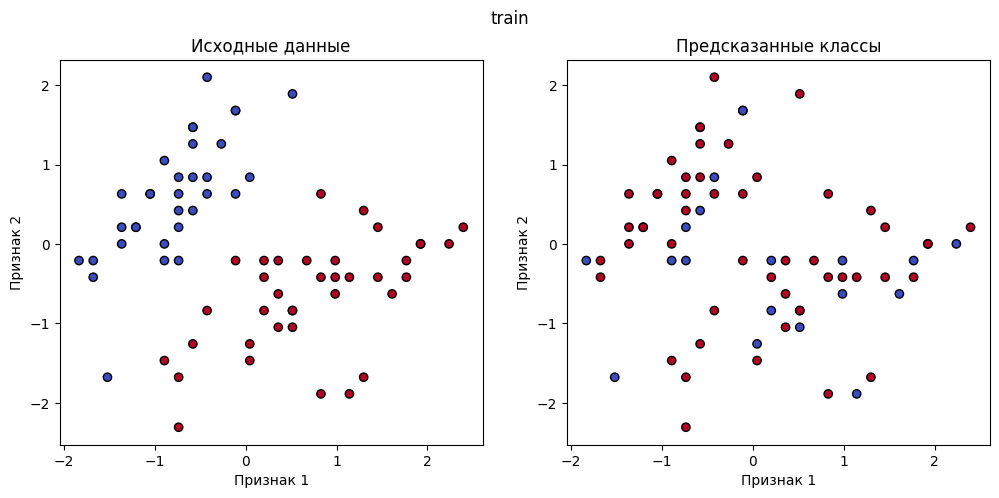

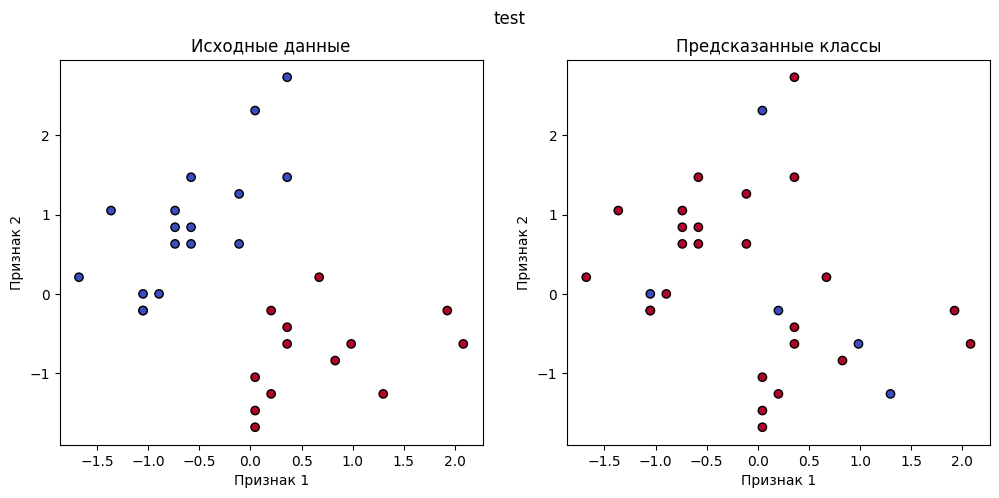

Accuracy: 40.00%


In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Генерация данных
# X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
 
# Load the Iris dataset
iris = load_iris()
# We only take the first two
# features for simplicity
X = iris.data[iris.target != 2, :2]  # Берем первые два класса и два признака
y = iris.target[iris.target != 2]
y = np.where(y == 0, -1, 1)

# Нормализация данных
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Снижение размерности до 2D с помощью PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# Инициализация и обучение SVM
smo = KeerthiSmo(X_train, y_train, C = 0.5)
smo.set_kernel('gaussian')
smo.train()

# Визуализация
Z_train = smo.predict(X_train)
Z_test = smo.predict(X_test)

plot_data(X_train,y_train, Z_train, 'train')
plot_data(X_test, y_test, Z_test, 'test')
accuracy = np.mean(Z_test.flatten() == y_test.flatten())
print(f"Accuracy: {accuracy*100:.2f}%")